In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns

In [2]:
# https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python
df = pd.read_csv('Mall_Customers.csv')

For this exercise we use a small dataset from Kaggle which is targetted at segmenting the customers.

In [3]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


As we look at the dataset, we cannot use 2 columns. CustomerID is not representing any usefull data and Gender is categoric. For our 2 algoritms (k-means, pam) we're calculating distance between vectors.

In [7]:
df = df.drop(columns=['CustomerID', 'Gender'])

In [5]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


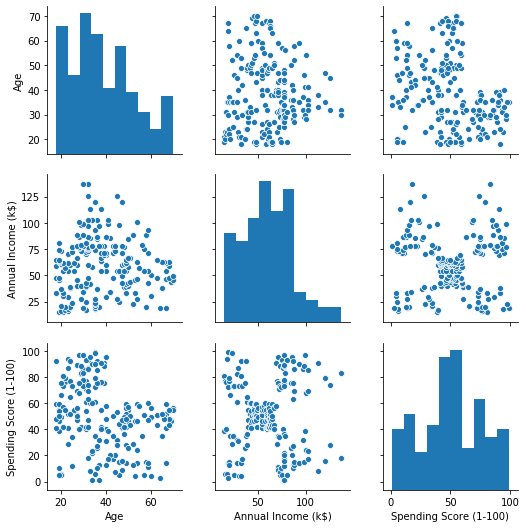

In [6]:
sns.pairplot(df)

By looking at the pairplot we see that there are some expected clusters in the spending-income data pair.

Let's run our algorithms and see if they are able to find them.

In [4]:
%cd ..

C:\Users\j\PycharmProjects\lnu_ht19_4ME310_assignment2


In [11]:
from src.clustering import PAM
from src.clustering import KMeans
import src.distance

As KMeans is very fast we can use it to find the optimal cluster size using elbow method. As our implementation is very naive we will run it 5 times at each number of clusters and select the lowest inertia value.

In [10]:
inertia_values = []
for i in range(1, 10):
    tmp = []
    for j in range(5):
        alg = KMeans(n_clusters=i, distance=src.distance.euclidean_distance, verbose=False)
        alg.fit(df)
        tmp.append(alg.inertia)
    inertia_values.append(min(tmp))

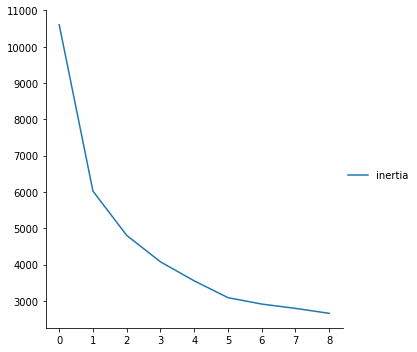

In [12]:
vals_df = pd.DataFrame(inertia_values, columns=['inertia'])
sns.relplot(data=vals_df, kind='line')

We see that optimal number of clusters is probably 5.

In [13]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, distance=src.distance.euclidean_distance, verbose=False)
pam = PAM(n_clusters=n_clusters, distance=src.distance.manhattan_distance, verbose=False)

In [18]:
def show_pairplot(df, labels):
    xdf = df.copy()
    xdf['label'] = [f'l{i}' for i in labels]
    return sns.pairplot(xdf, hue='label')

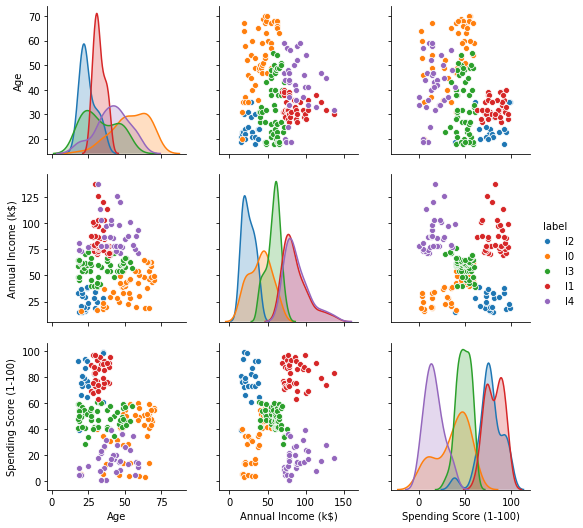

In [22]:
kmeans.fit(df)

show_pairplot(df, kmeans.predict(df))

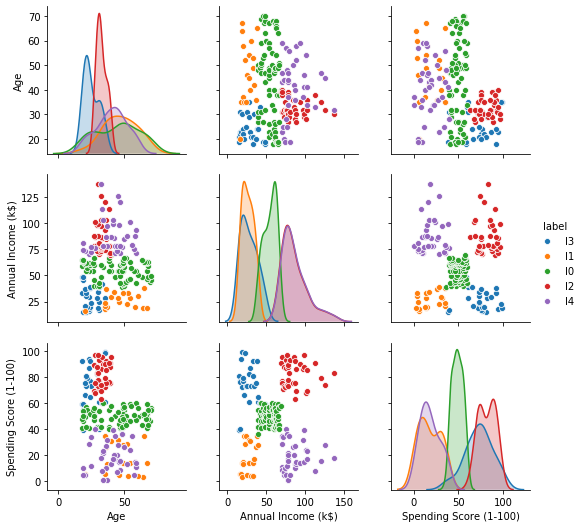

In [19]:
pam.fit(df)

show_pairplot(df, pam.predict(df))

We can decrease the dimensionality (not really that usefull when we have only 3 features) using PCA to have nice x,y scatter plot.

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df2 = pd.DataFrame(pca.fit_transform(df), columns=['pca_x', 'pca_y'])

sns.scatterplot(data=df2, x='pca_x', y='pca_y')

In [32]:
def pca_scatterplot_with_labels(df, labels):
    xdf = df.copy()
    xdf['label'] = [f'l{i}' for i in labels]

    return sns.scatterplot(data=xdf, x='pca_x', y='pca_y', hue='label')

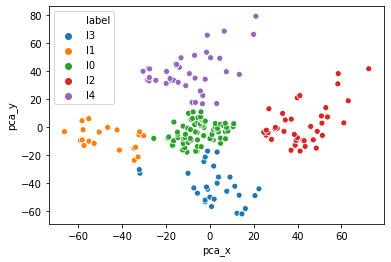

In [33]:
pca_scatterplot_with_labels(df2, pam.predict(df))

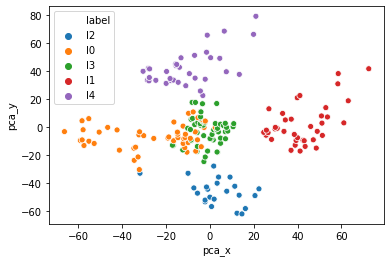

In [34]:
pca_scatterplot_with_labels(df2, kmeans.predict(df))

We can see that in this case (and execution of kmeans) it got a bit worse results than PAM. Looking back at the pairplots we can see the differences too. Bear in mind that executing it again might improve the results.

For this simple dataset we probably don't even need the clustering but the principles can be used on any other dataset.

One thing we didn't do is scaling the values -> so they all have the same impact on the distances.
We can for example use min-max scaling. 

In [36]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [35]:
from src.transform import min_max

df_scaled = df.apply(min_max, axis=0)

In [37]:
df_scaled.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,0.400962,0.373443,0.502041
std,0.268635,0.215285,0.263505
min,0.000000,0.000000,0.000000
25%,0.206731,0.217213,0.344388
50%,0.346154,0.381148,0.500000
75%,0.596154,0.516393,0.734694
max,1.000000,1.000000,1.000000


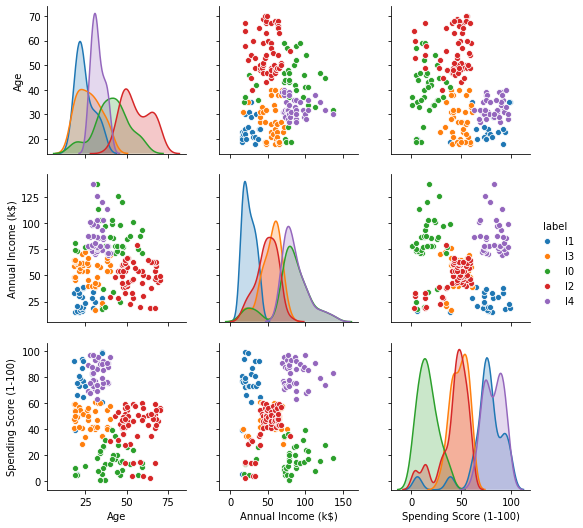

In [40]:
pam.fit(df_scaled)

show_pairplot(df, pam.predict(df_scaled))

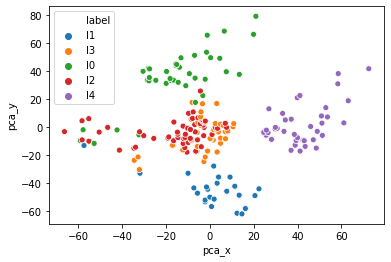

In [41]:
pca_scatterplot_with_labels(df2, pam.predict(df_scaled))

We see that we got actually worse results using PAM on scaled values. This might be because for this domain (shopping) annual income is definitely more important than age. Also the aren't any big outliers in the dataset.

In real world case there we would have to deal with missing values (and strategies to replace them), outliers, normalizing the distributions and also scaling the values. Gender might have a role in the clustering but unfortunately the algorithms we implemented are not able to handle categorical values so we dropped it. 

This notebook is only simple example of how we could do the clustering workflow.